In [14]:
# import libraries
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.simplefilter(action='ignore', category=FutureWarning)

In [97]:
df = pd.read_csv('/content/bank_transactions.csv')

In [98]:
# first look at data
print(df.info())
print(df.head())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
None
  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2     

In [99]:
# clean data: in CustomerDOB, replace faulty data with NaN
df['CustomerDOB'].replace('1/1/1800', np.nan, inplace=True)
print(df[df['CustomerDOB']=='1/1/1800'])

Empty DataFrame
Columns: [TransactionID, CustomerID, CustomerDOB, CustGender, CustLocation, CustAccountBalance, TransactionDate, TransactionTime, TransactionAmount (INR)]
Index: []


In [100]:
# clean data: turn CustomerDOB into date
df['CustomerDOB'] = df['CustomerDOB'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%y') if type(x) == str else None)

# correct DOB if birth year is greater than today (ex: /54 converted as /2054 instead of /1954)
for i in range(len(df['CustomerDOB'])):
  if df.loc[i, 'CustomerDOB'] > pd.Timestamp.today():
    df.loc[i, 'CustomerDOB'] = df.loc[i, 'CustomerDOB'] - pd.DateOffset(years=100)
  else:
    continue

In [101]:
# clean data: convert CustomerDOB to CustomerAge
df['CustomerAge'] = ''
for i in range(len(df.CustomerDOB)):
    if df.loc[i, 'CustomerDOB'] != None:
      df.loc[i, 'CustomerAge'] = (pd.Timestamp.today() - df.loc[i, 'CustomerDOB']).days // 365.25

df['CustomerAge'] =  pd.to_numeric(df['CustomerAge'])

In [102]:
# create a new variable: create a NumApperance to indicate how many times the CustomerID appears in the dataset, ie, frequent customer.
num_appearance = df['CustomerID'].value_counts()
df['NumAppearance'] = df['CustomerID'].map(num_appearance)

# I noticed some CustomerIDs had different DOB/Gender/Location. I'm assuming this is because
# it's not a real dataset. If I were to run into a similar situation in real life, I would investigate why this might be happening
# but for the purpose of this project, I'm going to merge some rows so that each customer has its own unique CustomerID.

In [103]:
# drop NA and duplicate IDs
df.dropna(inplace=True)
df.drop_duplicates(subset=['CustomerID'], inplace=True)
df = df.reset_index(drop=True)

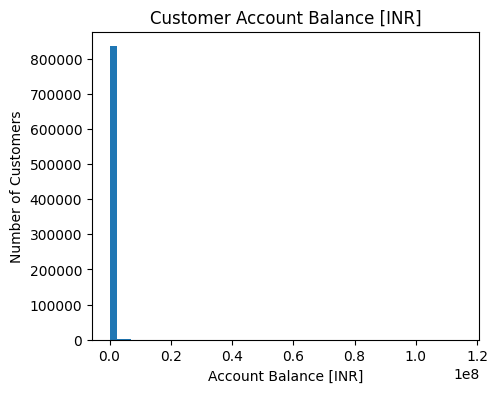

count    8.390810e+05
mean     1.053867e+05
std      8.024444e+05
min      0.000000e+00
25%      4.555840e+03
50%      1.598306e+04
75%      5.375908e+04
max      1.150355e+08
Name: CustAccountBalance, dtype: float64

In [104]:
# visualize data: account balance
plt.figure(figsize=(5,4))
plt.hist(df['CustAccountBalance'], bins=50)
plt.title('Customer Account Balance [INR]')
plt.ylabel('Number of Customers')
plt.xlabel('Account Balance [INR]')
plt.show()
df['CustAccountBalance'].describe()

# 0~ 16,974 ~115,035,500

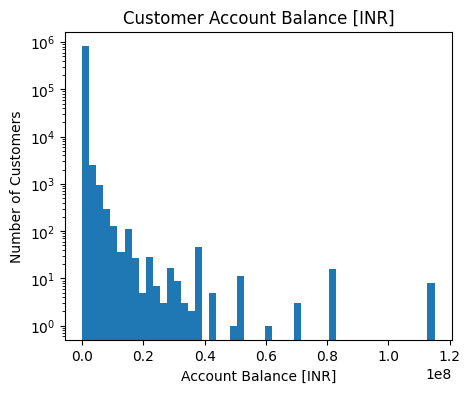

count    8.390810e+05
mean     1.053867e+05
std      8.024444e+05
min      0.000000e+00
25%      4.555840e+03
50%      1.598306e+04
75%      5.375908e+04
max      1.150355e+08
Name: CustAccountBalance, dtype: float64

In [105]:
# account balance is highly skewed, so using log histogram to get a better sense of the data spread.
plt.figure(figsize=(5,4))
plt.hist(df['CustAccountBalance'], bins=50, log=True)
plt.title('Customer Account Balance [INR]')
plt.ylabel('Number of Customers')
plt.xlabel('Account Balance [INR]')
plt.show()
df['CustAccountBalance'].describe()

# 0~ 16,974 ~115,035,500

In [106]:
# acc balance distribution is highly skewed, so I removed top 2% from clustering model
# since k means  can be sensitive to outliers. For the purpose of marketing or product development
# I think it makes sense to treat customers with high account balance as its own group
top2pct = np.percentile(df['CustAccountBalance'], 98)
print(top2pct)

df = df[df['CustAccountBalance'] < top2pct]
df.reset_index(drop=True, inplace=True)

837015.82


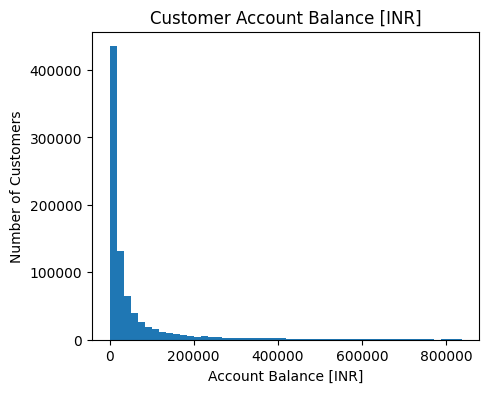

count    836969.000000
mean      55812.994507
std      111036.919860
min           0.000000
25%        4425.970000
50%       15350.960000
75%       49135.130000
max      836968.680000
Name: CustAccountBalance, dtype: float64

In [129]:
# visualize data: account balance
plt.figure(figsize=(5,4))
plt.hist(df['CustAccountBalance'], bins=50)
plt.title('Customer Account Balance [INR]')
plt.ylabel('Number of Customers')
plt.xlabel('Account Balance [INR]')
plt.show()
df['CustAccountBalance'].describe()

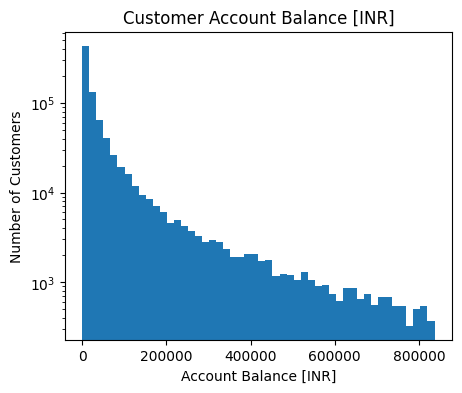

count    836969.000000
mean      55812.994507
std      111036.919860
min           0.000000
25%        4425.970000
50%       15350.960000
75%       49135.130000
max      836968.680000
Name: CustAccountBalance, dtype: float64

In [130]:
# visualize data: log account balance
plt.figure(figsize=(5,4))
plt.hist(df['CustAccountBalance'], bins=50, log=True)
plt.title('Customer Account Balance [INR]')
plt.ylabel('Number of Customers')
plt.xlabel('Account Balance [INR]')
plt.show()
df['CustAccountBalance'].describe()

In [132]:
# clean data: CustGender
df['CustGender'].replace('T', np.nan, inplace=True)
df['CustGender'].value_counts()
df.loc[df['CustGender'] == 'T']

# clean data: str to num
df['CustGender'] = df['CustGender'].apply(lambda x: 0 if x == 'F' else 1)

In [110]:
# merge the current dataset with a different dataset that maps cities to population
india_cities = pd.read_csv('/content/india_cities.csv')
print(india_cities.info())
print(india_cities.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name_of_city                    493 non-null    object 
 1   state_code                      493 non-null    int64  
 2   state_name                      493 non-null    object 
 3   dist_code                       493 non-null    int64  
 4   population_total                493 non-null    int64  
 5   population_male                 493 non-null    int64  
 6   population_female               493 non-null    int64  
 7   0-6_population_total            493 non-null    int64  
 8   0-6_population_male             493 non-null    int64  
 9   0-6_population_female           493 non-null    int64  
 10  literates_total                 493 non-null    int64  
 11  literates_male                  493 non-null    int64  
 12  literates_female                493 

In [111]:
# merge the two datasets: prep
population = india_cities[['name_of_city', 'population_total']]

population.loc[:, 'name_of_city'] = population['name_of_city'].str.upper()
population.loc[:, 'name_of_city'] = population['name_of_city'].str.rstrip(' ')
df = df.rename(columns={'CustLocation': 'City'})
population = population.rename(columns={'name_of_city': 'City', 'population_total': 'Population'})

In [112]:
# after merging the two dataset, discovered missing cities, so went back to add a population data for the most frequently appearing cities
missing_cities = [
    {'Population': 2341000, 'City': 'GHAZIABAD'},
     {'Population': 8450000, 'City': 'AHMEDABAD'},
      {'Population': 206000, 'City': 'MOHALI'},
       {'Population': 2341000, 'City': 'GHAZIABAD'},
        {'Population': 7950000, 'City': 'RANGA REDDY'}
    ]
missing_cities = pd.DataFrame(missing_cities)
population = pd.concat([population, missing_cities], ignore_index=True)

In [114]:
 new_names = {
      'MUMBAI': 'GREATER MUMBAI',
      'NOIDA': 'GREATER NOIDA',
      'HYDERABAD': 'GREATER HYDERABAD',
      'BANGALORE': 'BENGALURU',
      'AHMEDABAD': 'AHMADABAD',
      'BARODA': 'VADODARA',
      'CALCUTTA': 'KOLKATA',
      'THIRUVANANTHAPURAM': 'TRIVANDRUM',
      'VIZAG': 'VISAKHAPATNAM',
      'MOHALI': 'S.A.S. NAGAR',
      'ERNAKULAM': 'KOCHI'
      }

df['City'] = df['City'].replace(new_names)

In [115]:
# merge the two datasets
df = pd.merge(df, population, on='City', how='left')
print(df.shape)

print('Population null: ', df.Population.isna().sum())

(836969, 12)
Population null:  142197


In [116]:
# min population value in the india_cities dataset is 100,036, so imputing 100000 for locations wiht missing population, instead of dropping them
df['Population'].replace(np.nan, 100000, inplace=True)

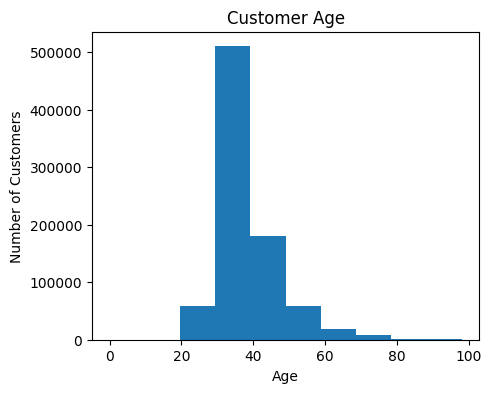

count    836969.000000
mean         38.137567
std           8.593703
min           0.000000
25%          32.000000
50%          36.000000
75%          41.000000
max          98.000000
Name: CustomerAge, dtype: float64

In [117]:
# visualize data: age
plt.figure(figsize=(5,4))
plt.hist(df['CustomerAge'])
plt.title('Customer Age')
plt.ylabel('Number of Customers')
plt.xlabel('Age')
plt.show()

df['CustomerAge'].describe(include='all')

CustGender
1    604459
0    232510
Name: count, dtype: int64


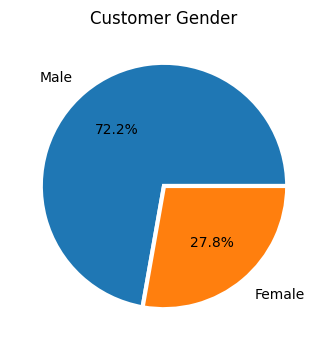

In [118]:
# visualize data: gender
print(df['CustGender'].value_counts())
labels = ['Male', 'Female']
plt.figure(figsize=(5,4))
plt.pie(df['CustGender'].value_counts(), labels=labels, labeldistance=1.15,
        wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')
plt.title('Customer Gender')
plt.show()

In [119]:
# visualize data: location
location = df[['City']].value_counts()[:10].reset_index()
print('Top 10 Most Frequently Mentioned Cities')
print(location)

Top 10 Most Frequently Mentioned Cities
                City  count
0     GREATER MUMBAI  80435
1          BENGALURU  66976
2          NEW DELHI  62506
3            GURGAON  58507
4              DELHI  56329
5      GREATER NOIDA  29246
6          GHAZIABAD  24352
7            CHENNAI  23053
8               PUNE  20314
9  GREATER HYDERABAD  18320


In [120]:
# visualize data: number of transaction made
df['NumAppearance'].value_counts()

NumAppearance
1    694278
2    124082
3     16747
4      1699
5       147
6        16
Name: count, dtype: int64

In [121]:
# identify features to include in k means model
df1 = df[['CustGender', 'CustAccountBalance', 'Population', 'CustomerAge', 'NumAppearance']]

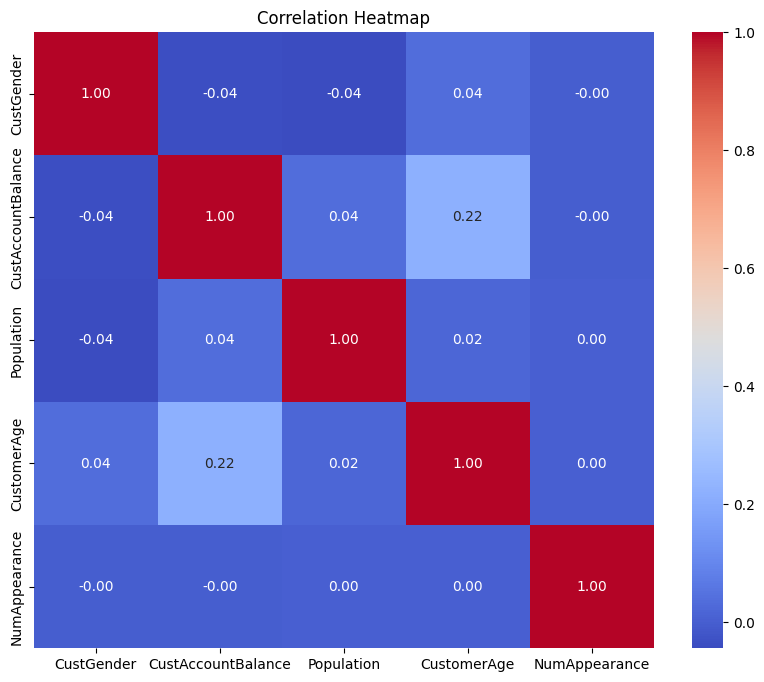

In [123]:
# visualize data: correlation heatmap. Check for features that are highly correlated with another feature
correlation_matrix = df1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [124]:
# standardize features
scaler = StandardScaler()
scaler.fit(df1)
X = scaler.transform(df1)

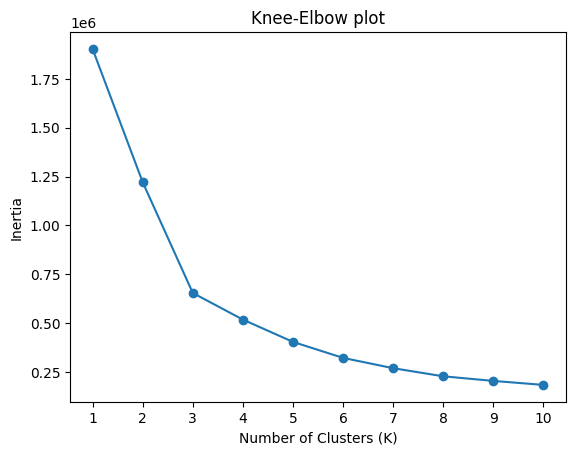

In [125]:
# run PCA and identify optimal number of clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

ks = range(1, 11)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Knee-Elbow plot')
plt.xticks(ks)
plt.show()

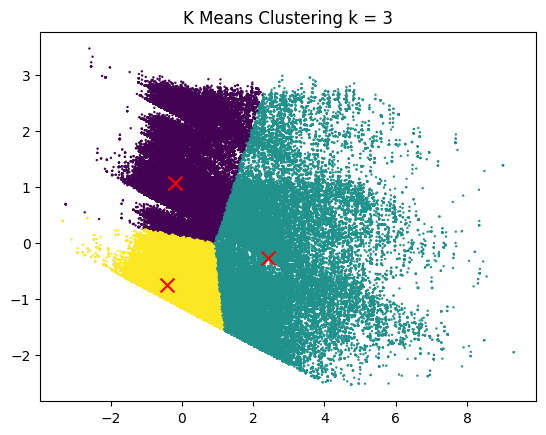

In [126]:
#  choose 3 as n_clusters and run KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=0.5, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=100, c='red')
plt.title('K Means Clustering k = 3')
plt.show()

In [127]:
# 'CustGender', 'CustAccountBalance', 'Population', 'CustomerAge', 'NumAppearance'
centers_pca_inversed = pca.inverse_transform(centers)
centers_pca_scaler_inversed = scaler.inverse_transform(centers_pca_inversed)
print(centers_pca_scaler_inversed)

[[3.67487456e-01 4.43772656e+04 6.33729918e+06 3.49282848e+01
  1.21191689e+00]
 [7.70722988e-01 2.42536110e+05 4.74322154e+06 5.28898899e+01
  1.19318998e+00]
 [9.83645191e-01 2.15710986e+04 1.23800719e+06 3.72044352e+01
  1.18273040e+00]]


In [128]:
# Cluster 1: female with a balance of  44,377 INR in their account, living in a city with population of 6,337,299, age 35yo, and made 1 transaction bw 2016-08-01 and 2016-10-21
# Cluster 2:  male  with a balance of 242,536 INR in their account, living in a city with population of 4,743,222, age 53yo, and made 1 transaction bw 2016-08-01 and 2016-10-21
# Cluster 3:  male  with a balance of  21,571 INR in their account, living in a city with population of 1,238,007, age 37yo, and made 1 transaction bw 2016-08-01 and 2016-10-21